In [2]:
## Import Libraries ##
import os
import numpy as np
import random
import tqdm
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier

In [14]:
## Data Loading ##

# Random seed
np.random.seed(3579)

# Paths to directory
training_set_dir = "data/Train"
test_set_dir = "data/Test"

# Initialize lists for training and testing data
x_train = []
y_train = []
x_test = []
y_test = []

# Function to process a directory (Train or Test)
def process_directory(directory, is_train=True):
    image_data = []
    labels = []

    # Progress bar
    total_images = sum(len(files) for _, _, files in os.walk(directory))
    print(f'Total images to process in {directory}:', total_images)
    pbar = tqdm.tqdm(total=total_images, desc=f"Processing {directory} Images", unit="image", leave=True)

    # Image augmentation
    def augment_image(img):
        # enhance brightness to simulate different lighting conditions
        enhancer = ImageEnhance.Brightness(img)
        brightness_increase = random.uniform(1, 1.75)
        img_bright = enhancer.enhance(brightness_increase)

        # return [img_rotated, img_flipped, img_bright]
        return [img_bright]

    # Iterate through each folder in the directory
    for subdir, dirs, files in os.walk(directory):
        for dir_name in dirs:
            dir_path = os.path.join(subdir, dir_name)
            file_names = os.listdir(dir_path)
            for file_name in file_names:
                file_path = os.path.join(dir_path, file_name)
                if file_path.endswith(('.png', '.jpg', '.jpeg')):  # Ensure it is an image file
                    img = Image.open(file_path).convert('L')
                    img = img.resize((28, 28)) # resize to 28x28
                    img_matrix = np.array(img)
                    image_data.append(img_matrix)
                    labels.append(dir_name)

                    # Augmenting images for both training and testing datasets
                    augmented_images = augment_image(img)
                    for aug_img in augmented_images:
                        aug_img_matrix = np.array(aug_img)
                        image_data.append(aug_img_matrix)
                        labels.append(dir_name)
                    
                    # Ensure enough images per digit class
                    if dir_name.isdigit():
                        while labels.count(dir_name) < 100:
                            extra_augmented_images = augment_image(img)
                            for extra_img in extra_augmented_images:
                                extra_img_matrix = np.array(extra_img)
                                image_data.append(extra_img_matrix)
                                labels.append(dir_name)
                    pbar.update(1)

    pbar.close()

    return np.array(image_data), np.array(labels)

# Process the training and test directories
x_train, y_train = process_directory(training_set_dir, is_train=True)
x_test, y_test = process_directory(test_set_dir, is_train=False)

# Flatten the data
X_train_flat = x_train.reshape(len(x_train), -1)
X_test_flat = x_test.reshape(len(x_test), -1)

print("Training data shape:", x_train.shape)
print("Training labels shape:", y_train.shape)
print("Test data shape:", x_test.shape)
print("Test labels shape:", y_test.shape)

Total images to process in data/Train: 19949


Processing data/Train Images:   0%|          | 0/19949 [00:00<?, ?image/s]

Processing data/Train Images: 100%|██████████| 19949/19949 [00:04<00:00, 4268.21image/s]


Total images to process in data/Test: 7312


Processing data/Test Images: 100%|██████████| 7312/7312 [00:01<00:00, 4602.96image/s]

Training data shape: (40878, 28, 28)
Training labels shape: (40878,)
Test data shape: (15604, 28, 28)
Test labels shape: (15604,)


Label = O


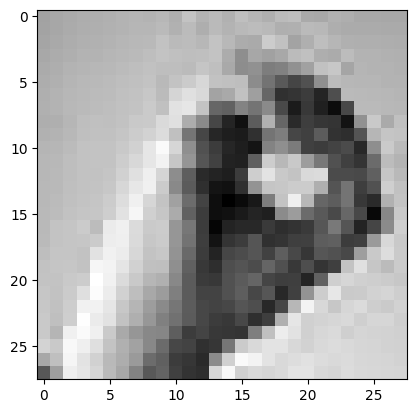

Label = L


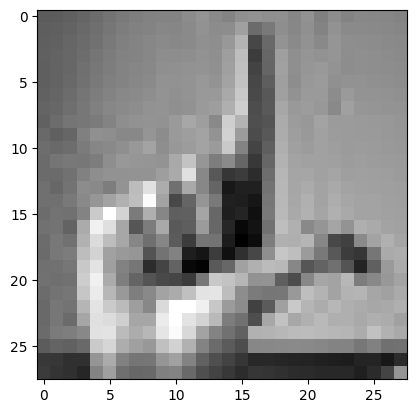

In [16]:
# Examples
plt.imshow(x_train[10000], cmap='gray') 
print('Label =',y_train[10000])
plt.show()
plt.imshow(x_train[15000], cmap='gray')
print('Label =',y_train[15000])
plt.show()


In [17]:
## Random Forest ##

# Initialize the model
rf = RandomForestClassifier()

# create grid search
param_grid_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, 20, 50, 100]
}

grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit the model
grid_search_rf.fit(X_train_flat, y_train)

# retrieve best model
best_rf = grid_search_rf.best_estimator_

# Predict
y_pred_rf = best_rf.predict(X_test_flat)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

print("Random Forest:")
print(classification_report(y_test, y_pred_rf))



Fitting 5 folds for each of 15 candidates, totalling 75 fits


KeyboardInterrupt: 

In [ ]:
## XGBoost ##

# Initialize the model
xgb = XGBClassifier()

# create grid search
param_grid_xgb = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, 20, 50],
    'learning_rate': [0.01, 0.1, 0.3]
}

grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=5, n_jobs=-1, verbose=1)

# Fit the model
grid_search_xgb.fit(X_train_flat, y_train)

# retrieve best model
best_xgb = grid_search_xgb.best_estimator_

# Predict
y_pred_xgb = best_xgb.predict(X_test_flat)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))

print("XGBoost:")
print(classification_report(y_test, y_pred_xgb))

In [4]:
## Neural Network ##
scalar = StandardScaler()

# fit to training data
scalar.fit(X_train_flat)
StandardScaler(copy=True, with_mean=True, with_std=True)

# transform training data
X_train_scaled = scalar.transform(X_train_flat)
X_test_scaled = scalar.transform(X_test_flat)

# specify model
mlp = MLPClassifier(max_iter=1000, random_state=42)

# create grid
grid = {
    'hidden_layer_sizes': [(250, 250), (100, 100), (50, 50)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.06, 0.01, 0.001, 0.02],
    'learning_rate': ['adaptive'],
}

grid_search = GridSearchCV(mlp, grid, n_jobs=-1)

# fit model
grid_search.fit(X_train_scaled, y_train)

# retrieve best model
mlp_best = grid_search.best_estimator_

# predict
y_pred_mlp = mlp_best.predict(X_test_scaled)
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
print(f"Accuracy: {accuracy_mlp}")
print("Classification Report:")
print(classification_report(y_test, y_pred_mlp))

# .76, (50,50), 0.01
# .78, (50,50), 0.02
# .79, (100,100), 0.025
# .80, (150, 150, 150), 0.05
# .81, (150,150), 0.03
# .83, (200,200), 0.05
# .82, (250,250), 0.06

Accuracy: 0.8176749551397078
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       126
           1       1.00      0.98      0.99       126
           2       1.00      0.99      1.00       126
           3       1.00      0.78      0.88       126
           4       0.99      1.00      1.00       126
           5       0.82      1.00      0.90       126
           6       0.97      1.00      0.98       126
           7       1.00      0.98      0.99       126
           8       1.00      1.00      1.00       126
           9       1.00      0.98      0.99       126
           A       0.84      0.97      0.90       662
           B       0.94      0.95      0.94       864
           C       0.78      1.00      0.87       620
           D       0.93      0.98      0.96       490
           E       0.91      0.99      0.95       996
           F       0.73      0.91      0.81       494
           G       0.86      

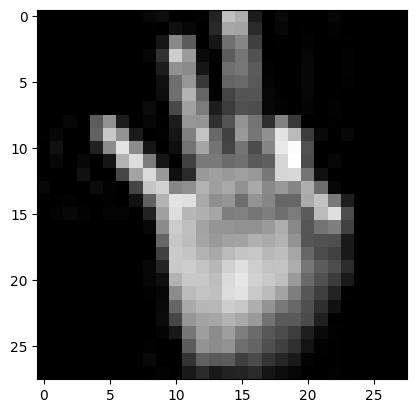

The predicted class for the image is: 9


In [45]:
## Display Image ##

def preprocess_image(image_path):
    img = Image.open(image_path).convert('L')
    img = img.resize((28, 28))
    img_array = np.array(img)
    return img_array

# Path to your image
image_path = 'data/Test/K/2_K.jpeg'

# test random forest model
test_model = best_rf

if test_model:
    # Preprocess the image
    preprocessed_image = preprocess_image(image_path)

    plt.imshow(preprocessed_image, cmap='gray')
    plt.show()
    # Predict the class
    predicted_class = test_model.predict(preprocessed_image.reshape(1,-1))[0]
    print(f'The predicted class for the image is: {predicted_class}')
else:
    print("RandomForestClassifier model was not successfully trained.")